In Amir(2012)[1], they measure the dependence of the relaxation both on time $t$ and on the "waiting time" $t_w$, during which an external perturbation has been applied. And the longer $t_w$ is, the slower the resulting relaxation.

In [2]:
import tamaas as tm
import tamaas.utils
import matplotlib.pyplot as plt
import numpy as np
import time

# parallel computation
tm.initialize(16)

# Initialize threads and fftw
tm.set_log_level(tm.LogLevel.info)  # Show progression of solver

# discretization
n = 1024

# Surface generator
sg = tm.SurfaceGeneratorFilter2D([n, n])
sg.random_seed = 1

# Spectrum
sg.spectrum = tm.Isopowerlaw2D()

# Parameters
sg.spectrum.q0 = 16
sg.spectrum.q1 = 16
sg.spectrum.q2 = 64
sg.spectrum.hurst = 0.8


In [ ]:

# Generating surface
surface = sg.buildSurface()
surface /= tm.Statistics2D.computeSpectralRMSSlope(surface)

np.save("surface.npy", surface)

plt.imshow(surface)


In [3]:

# Domain size
L = 1.

model = tm.Model(tm.model_type.basic_2d, [L, L], [n, n])

model.E = 3
model.nu = 0.5
model.E_star

shear_modulus = [3] * 500

characteristic_time = np.logspace(-3, 6, 500)


# time
t0 = 0
t1 = 50
time_steps = 300
dt = (t1 - t0) / time_steps

# Const loading
W = 1e0


In [ ]:
surface = np.load("surface.npy")

#solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#solver.solve(p_target)

#reset the solver to avoid history accumulation
solver.reset()


start_time = time.perf_counter()

for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas.append(tm.Statistics2D.contact(model.traction))

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time)
np.save("Ac_tamaas.npy", Ac_tamaas)

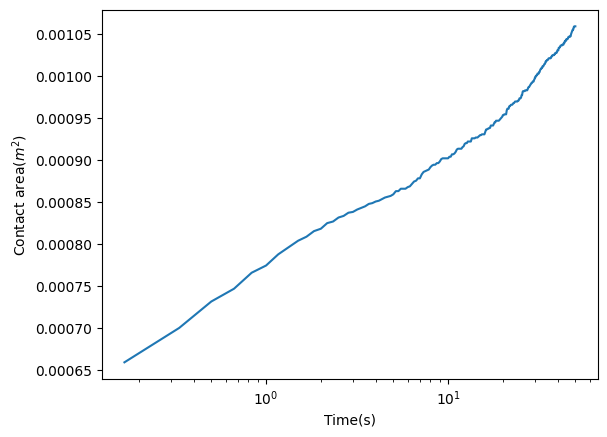

In [3]:
plt.plot(np.arange(t0, t1, dt)+dt, Ac_tamaas)
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.xscale("log")
plt.show()

### Q: The pertubation in the figure above may show that we need a compromise between our number of Maxwell branches and surface discrization?

#### Now we move to nonmonotonic aging

In [4]:
surface = np.load("surface.npy")

solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
solver.reset()

# Solve for target pressure
p_target1 = 1#avarge pressure
p_target2 = 0.25#avarge pressure

tm.Statistics2D.contact(model.traction)
model.traction[:] = 0
model.displacement[:] = 0

# Solve for target pressure
contact_area = []
for i in range(time_steps):
    model.traction[:] = 0
    model.displacement[:] = 0
    if i < 150:
        solver.solve(p_target1)
    else:
        solver.solve(p_target2)
    contact_area.append(tm.Statistics2D.contact(model.traction))

np.save("contact_area.npy", contact_area)

 Iter          Cost_f           Error
    0   -1.150757e+01    2.720844e+00
   64   -3.108583e+01    9.060930e-13
 Iter          Cost_f           Error
    0   -1.150244e+01    2.661294e+00
   62   -3.075025e+01    4.587616e-13
 Iter          Cost_f           Error
    0   -1.149959e+01    2.630322e+00
   64   -3.057496e+01    6.305137e-13
 Iter          Cost_f           Error
    0   -1.149757e+01    2.609286e+00
   65   -3.045565e+01    5.381413e-13
 Iter          Cost_f           Error
    0   -1.149601e+01    2.593304e+00
   64   -3.036485e+01    5.303091e-13
 Iter          Cost_f           Error
    0   -1.149471e+01    2.580390e+00
   64   -3.029146e+01    8.363573e-13
 Iter          Cost_f           Error
    0   -1.149361e+01    2.569541e+00
   63   -3.022974e+01    8.258892e-13
 Iter          Cost_f           Error
    0   -1.149264e+01    2.560177e+00
   63   -3.017646e+01    9.962539e-13
 Iter          Cost_f           Error
    0   -1.149178e+01    2.551933e+00
   63   -3.0

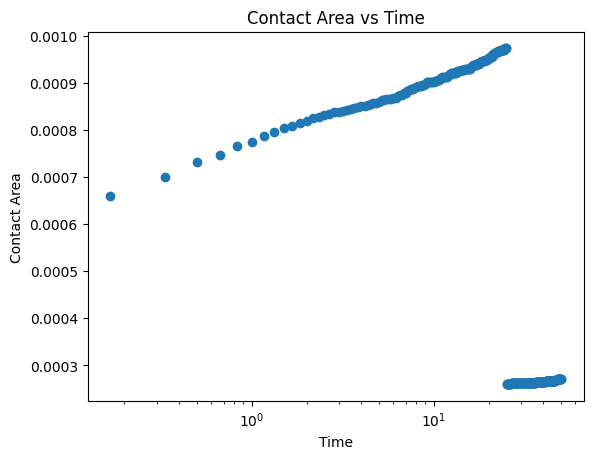

In [5]:

#plt.plot(range(time_steps), contact_area)
plt.scatter(np.arange(t0, t1, dt)+dt, contact_area)
plt.xlabel('Time')
plt.xscale("log")
plt.ylabel('Contact Area')
plt.title('Contact Area vs Time')
plt.show()

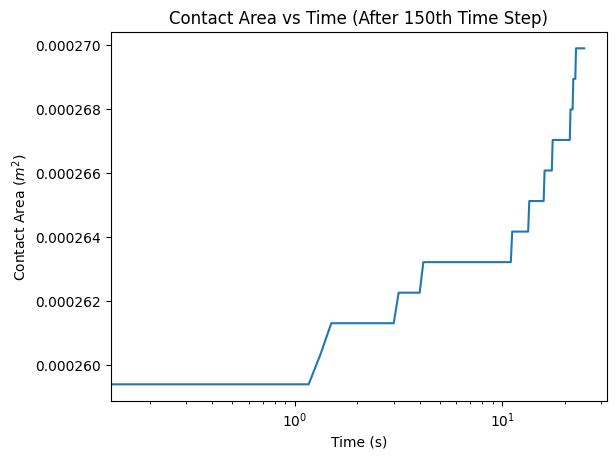

In [7]:
# Get the data after the 150th time step
contact_area_after_150 = contact_area[150:]

# Subtract the value of the 150th time step from all the time steps
time_after_150 = np.arange(0, len(contact_area_after_150)) * dt

# Plot the modified data
plt.plot(time_after_150, contact_area_after_150)
plt.xlabel("Time (s)")
plt.xscale("log")
plt.ylabel("Contact Area ($m^2$)")
plt.title("Contact Area vs Time (After 150th Time Step)")
plt.show()

Compared with experiment in Dilavou(2018)[2], it does look like we can get close to logarithmic aging. The deaging observed in Dillavou(2018)[2] looks difficult to get with our current model.



So we plan to have two analyses, we already know that the real contact area grows logarithmically in time, βlog(t - t*). First, we try `curve_fit` on the initial loading curve(first stage) for $\beta_1$ to see whether $\beta_1$ changes for different loading. Then we compare the $\beta_1$ and $\beta_2$ for aging stage and deaging stage.

#### 1. Different loading for first stage

In [2]:
surface = np.load("surface.npy")

#solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)


Ac_tamaas_bigger = []

W2 = 4e0

#solve for target pressure
p_target = W2 / (L**2) #avarge pressure
#solver.solve(p_target)

#reset the solver to avoid history accumulation
solver.reset()


start_time = time.perf_counter()

for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas_bigger.append(tm.Statistics2D.contact(model.traction))

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time)
np.save("Ac_tamaas_bigger.npy", Ac_tamaas_bigger)

 Iter          Cost_f           Error
    0   -4.599644e+01    2.721753e+00
   67   -1.110041e+02    9.822138e-13
 Iter          Cost_f           Error
    0   -7.755791e+01    3.850792e-02
   53   -1.094216e+02    5.855131e-13
 Iter          Cost_f           Error
    0   -7.689744e+01    2.035017e-02
   52   -1.085890e+02    7.273812e-13
 Iter          Cost_f           Error
    0   -7.643510e+01    1.386027e-02
   51   -1.080199e+02    5.417665e-13
 Iter          Cost_f           Error
    0   -7.608097e+01    1.061534e-02
   50   -1.075858e+02    8.877635e-13
 Iter          Cost_f           Error
    0   -7.579350e+01    8.853259e-03
   50   -1.072338e+02    7.832453e-13
 Iter          Cost_f           Error
    0   -7.555128e+01    7.131042e-03
   49   -1.069375e+02    8.585420e-13
 Iter          Cost_f           Error
    0   -7.534191e+01    6.264559e-03
   48   -1.066813e+02    9.679707e-13
 Iter          Cost_f           Error
    0   -7.515745e+01    5.402051e-03
   49   -1.0

Execution time: 476.5750162140466


In [3]:
surface = np.load("surface.npy")

#solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)


Ac_tamaas_delta = []

W_delta = W2 - W

#solve for target pressure
p_target = W_delta / (L**2) #avarge pressure
#solver.solve(p_target)

#reset the solver to avoid history accumulation
solver.reset()


start_time = time.perf_counter()

for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas_delta.append(tm.Statistics2D.contact(model.traction))

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time)
np.save("Ac_tamaas_delta.npy", Ac_tamaas_delta)

 Iter          Cost_f           Error
    0   -6.136901e+01    4.119276e-01
   56   -8.545478e+01    9.302592e-13
 Iter          Cost_f           Error
    0   -5.950553e+01    3.560671e-02
   52   -8.432106e+01    6.662790e-13
 Iter          Cost_f           Error
    0   -5.903463e+01    1.839535e-02
   50   -8.372566e+01    6.878778e-13
 Iter          Cost_f           Error
    0   -5.870561e+01    1.226809e-02
   49   -8.331926e+01    6.725702e-13
 Iter          Cost_f           Error
    0   -5.845379e+01    9.038291e-03
   46   -8.300917e+01    9.355350e-13
 Iter          Cost_f           Error
    0   -5.824909e+01    8.075635e-03
   48   -8.275762e+01    7.323120e-13
 Iter          Cost_f           Error
    0   -5.807657e+01    6.660375e-03
   47   -8.254591e+01    7.755238e-13
 Iter          Cost_f           Error
    0   -5.792760e+01    5.748617e-03
   47   -8.236281e+01    8.355662e-13
 Iter          Cost_f           Error
    0   -5.779615e+01    5.237792e-03
   48   -8.2

Execution time: 481.4097603270784


Then we can compare the $\beta$ value for three different loading(4, 1, 3)



Fitted beta: 6.100689153332618e-08
[[2.39921428e-19 5.83304277e-11]
 [5.83304277e-11 1.42386296e-02]]


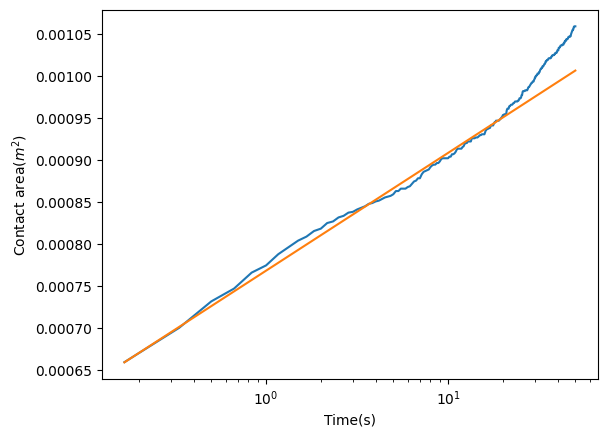

In [12]:
import numpy as np
from scipy.optimize import curve_fit
Ac_tamaas = np.load("Ac_tamaas.npy")
origin_contact_area = np.load("Ac_tamaas.npy")
# Define the target function
def target_func(t, beta, t_star):
    return beta * (t - t_star)/np.min(characteristic_time)

# Extract the relevant data
x_data_1 = np.arange(t0, t1, dt)[:150] + dt
x_data_1 = np.log(x_data_1)
y_data_1 = origin_contact_area[:150]

# Perform the curve fitting
popt_1, pcov_1 = curve_fit(target_func, x_data_1, y_data_1, p0=(1,np.min(characteristic_time)))

# Extract the fitted parameters
beta_1_fit, t_star_1_fit = popt_1

# Print the fitted parameter
print("Fitted beta:", beta_1_fit)
print(pcov_1)



plt.plot(np.arange(t0, t1, dt)+dt, Ac_tamaas)
plt.plot(np.arange(t0, t1, dt)+dt, target_func(np.log(np.arange(t0, t1, dt)+dt), beta_1_fit, t_star_1_fit))
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.xscale("log")
plt.show()

In [13]:
'''
import numpy as np
from scipy.optimize import curve_fit

bigger_contact_area = np.load("Ac_tamaas_bigger.npy")
# Define the target function
def target_func(t, beta, t_star):
    return beta * np.log(t - t_star)

# Extract the relevant data
x_data_big = np.arange(t0, t1, dt)[:150]
np.log(x_data_big)
y_data_big = bigger_contact_area[:150]

# Perform the curve fitting
popt_big, pcov_big = curve_fit(target_func, x_data_big, y_data_big)

# Extract the fitted parameters
beta_big_fit, t_star_big_fit = popt_big

# Print the fitted parameter
print("Fitted beta:", beta_big_fit)
'''



Fitted beta: 1.0


/tmp/ipykernel_349014/3349061491.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(x_data_big)
/tmp/ipykernel_349014/3349061491.py:7: RuntimeWarning: divide by zero encountered in log
  return beta * np.log(t - t_star)
/tmp/ipykernel_349014/3349061491.py:7: RuntimeWarning: invalid value encountered in log
  return beta * np.log(t - t_star)
/tmp/ipykernel_349014/3349061491.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_big, pcov_big = curve_fit(target_func, x_data_big, y_data_big)


Fitted beta: 2.702650409517145e-07
[[4.73903483e-18 2.20993108e-10]
 [2.20993108e-10 1.03629923e-02]]


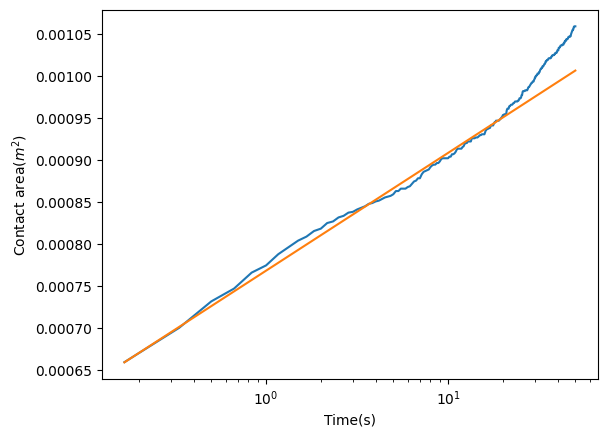

In [14]:
import numpy as np
from scipy.optimize import curve_fit
Ac_tamaas = np.load("Ac_tamaas.npy")
bigger_contact_area = np.load("Ac_tamaas_bigger.npy")
# Define the target function
def target_func(t, beta, t_star):
    return beta * (t - t_star)/np.min(characteristic_time)

# Extract the relevant data
x_data_big = np.arange(t0, t1, dt)[:150] + dt
x_data_big = np.log(x_data_big)
y_data_big = bigger_contact_area[:150]

# Perform the curve fitting
popt_big, pcov_big = curve_fit(target_func, x_data_big, y_data_big, p0=(1,np.min(characteristic_time)))

# Extract the fitted parameters
beta_big_fit, t_star_big_fit = popt_big

# Print the fitted parameter
print("Fitted beta:", beta_big_fit)
print(pcov_big)



plt.plot(np.arange(t0, t1, dt)+dt, Ac_tamaas)
plt.plot(np.arange(t0, t1, dt)+dt, target_func(np.log(np.arange(t0, t1, dt)+dt), beta_1_fit, t_star_1_fit))
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.xscale("log")
plt.show()

#### 2. $\beta_1$ and $\beta_2$ for aging stage and deaging stage

In [6]:


contact_area = np.load("contact_area.npy")

# Define the target function
def target_func(t, beta, t_star):
    return beta * np.log(t - t_star)

# Extract the relevant data
x_data = np.arange(t0, t1, dt)[:150]
np.log(x_data)
y_data = contact_area[:150]

# Perform the curve fitting
popt, pcov = curve_fit(target_func, x_data, y_data)

# Extract the fitted parameters
beta_1_fit, t_star_fit = popt

# Print the fitted parameter
print("Fitted beta:", beta_1_fit)

Fitted beta: 1.0


/tmp/ipykernel_345065/401701866.py:9: RuntimeWarning: divide by zero encountered in log
  np.log(x_data)
/tmp/ipykernel_345065/401701866.py:5: RuntimeWarning: divide by zero encountered in log
  return beta * np.log(t - t_star)
/tmp/ipykernel_345065/401701866.py:5: RuntimeWarning: invalid value encountered in log
  return beta * np.log(t - t_star)
/tmp/ipykernel_345065/401701866.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(target_func, x_data, y_data)


In [5]:
# Extract the relevant data
x_2_data = np.arange(t0, t1, dt)[150:]
np.log(x_2_data)
y_2_data = contact_area[150:]

# Perform the curve fitting
popt2, pcov2 = curve_fit(target_func, x_2_data, y_2_data)

# Extract the fitted parameters
beta_2_fit, t_star_2_fit = popt2

# Print the fitted parameter
print("Fitted beta:", beta_2_fit)

Fitted beta: 5.318722455305953e-05


#### Reference



[1] Amir, Ariel, Yuval Oreg, and Yoseph Imry. ‘On Relaxations and Aging of Various Glasses’. Proceedings of the National Academy of Sciences 109, no. 6 (7 February 2012): 1850–55. https://doi.org/10.1073/pnas.1120147109.

[2] Dillavou, Sam, and Shmuel M. Rubinstein. ‘Nonmonotonic Aging and Memory in a Frictional Interface’. Physical Review Letters 120, no. 22 (1 June 2018): 224101. https://doi.org/10.1103/PhysRevLett.120.224101.
